# Choropleth map(s) of BEV concentration in Washington State

## In this notebook I walk through the process of building a few Choropleth maps that highlight the "population" of battery electric vehicles in the state by county and by city within a few select counties.

### Within Jupyter notebooks the Geopandas library is not already installed. I am installing through !pip install

In [1]:
#install geopandas 

!pip install geopandas

### Need to import os model. this provides a way to interact with the operating sytem allowing access to environment variables. In this example we are using shapefiles( .shx) to build a map. Below we set the SHAPE_RESTORE_SHX to Yes emabling the system to restore/read the .shx files.

In [2]:
## import os. SHAPE_RESTORE_SHX is a variable related to shapefilehandling. Shapefiles often come with an auxiliary file 
## with the extentsion .shx (shape file index). This file contains index data that helps in restoring or using the geometry
## information effectively (per ChatGT)

import os
os.environ["SHAPE_RESTORE_SHX"] = "YES"

### Import libraries and the files we will be working with. Create a main data frame of battery electric vehicles (BEV). Create a path to the map(shapefile) to leverage when building the map highlighting the BEV populations by county. I found map (and other maps) of Washington state broken out by counties through Chat GPT, MS Copilot, and Bing. Note - the map file comes in a zip file. Download the entire zipfile and save unzipped. Though you will directly save the .shp file to notebook, the other files are needed via GeoPandas: 
### 1) .shp (Shapefile): This file contains the geometry of the features (e.g., points, lines, polygons).
### 2) .shx (Shape Index file): This file is an index that allows software to quickly find features within the .shp file
### 3)  .dbf (Attribute Table): This file stores the attribute data for each feature in a tabular format

In [3]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

#pull in data file and map file
df = pd.read_csv(r'C:\Users\v-joecamp\OneDrive - Microsoft\Desktop\Python Beginner Projects\EV stats\Electric_Vehicle_Population_Data_09292024.csv')
shape_path = r'C:\Users\v-joecamp\OneDrive - Microsoft\Desktop\Python Beginner Projects\EV stats\tl_2016_53_cousub.shp'

In [5]:
## let's take look at the column names the data frame 

print(df.columns)


Index(['County', 'City', 'State', 'COUNTYFP', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Kwh battery', 'kW fast DC charging',
       'Legislative District', 'Vehicle Location', 'Electric Utility'],
      dtype='object')


### Build a shape geo dataframe via geopandas and look at the list of columns.

In [6]:
## Need to convert the shape_path into a geo data frame. And we'l look at the column names.

shape = gpd.read_file(shape_path)
print(shape.columns)

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')


### The current dataframe contains both battery electric vehicles (BEV) and plug in hybrid cars. I want to make a dataframe of just BEV. Then look at the column information on the new dataframe to understand naming convention for each column, data types and count for each column. 

In [7]:
## creating a BEV dataframe

bev_df = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
bev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161197 entries, 1 to 204966
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   County                                             161197 non-null  object 
 1   City                                               161197 non-null  object 
 2   State                                              161197 non-null  object 
 3   COUNTYFP                                           161197 non-null  int64  
 4   Postal Code                                        161197 non-null  int64  
 5   Model Year                                         161197 non-null  int64  
 6   Make                                               161197 non-null  object 
 7   Model                                              161197 non-null  object 
 8   Electric Vehicle Type                              161197 non-null  object 
 9 

### I want to build a BEV dataframe by county - use the groupby function. This dataframe will show the number of BEVs per county which will be reflected in the Choropleth map once built.  

In [8]:
#a list of the counties and COUNTYFP in Washington State and count of BEV cars in each. COUNTYFP means County Federal 
## Information Processing Standards (FIPS)code. This is code for each county in the U.S. by the Census Bureau.  I added the 
## COUNTYFP column to the original data set. COUNTYFP will be the "key" between df_bev_county and the shape file. 

df_bev_county = bev_df.groupby(['County','COUNTYFP']).size().reset_index(name='Count')

df_bev_county.head()

,County,COUNTYFP,Count
0,Adams,1,44
1,Asotin,3,56
2,Benton,5,1791
3,Chelan,7,976
4,Clallam,9,843


### Build a shape geo dataframe via geopandas and take a look at the information in the COUNTYFP fields to confirm a match with the same column in df_bev_county

In [9]:
## Printing the COUNTYFP columns to confirm the numbers are the same as the 
## COUNTYFP column in df_bev_county

print(shape['COUNTYFP'])

0      003
1      003
2      075
3      075
4      075
      ... 
237    027
238    027
239    027
240    027
241    027
Name: COUNTYFP, Length: 242, dtype: object


### Look at the data types of the shape df - specifically the data type of the COUNTYFP column. This needs to be the same data type as those in the same column from df_bev_county. As you can see the COUNTFP data type is "object" - this needs to be changed to int. 

In [10]:
## Look t the column names, count, and datatypes of each column. Notice that COUNTYFP is an object. As this is a key, this 
## data type needs to be changed to an int

shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   242 non-null    object  
 1   COUNTYFP  242 non-null    object  
 2   COUSUBFP  242 non-null    object  
 3   COUSUBNS  242 non-null    object  
 4   GEOID     242 non-null    object  
 5   NAME      242 non-null    object  
 6   NAMELSAD  242 non-null    object  
 7   LSAD      242 non-null    object  
 8   CLASSFP   242 non-null    object  
 9   MTFCC     242 non-null    object  
 10  CNECTAFP  0 non-null      object  
 11  NECTAFP   0 non-null      object  
 12  NCTADVFP  0 non-null      object  
 13  FUNCSTAT  242 non-null    object  
 14  ALAND     242 non-null    int64   
 15  AWATER    242 non-null    int64   
 16  INTPTLAT  242 non-null    object  
 17  INTPTLON  242 non-null    object  
 18  geometry  242 non-null    geometry
dtypes: geometry(1), int64(2), object(16)
memor

### This block of code changes the data type in column COUNTYFP from object to int. Using the .info() function we can confirm the change was made. 

In [11]:
## changing the data type of the COUNTYFP column from an object to int. Now shape geo df and df_bev_county can "talk" to 
##each other. 

shape['COUNTYFP'] = shape['COUNTYFP'].astype(int)
shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   242 non-null    object  
 1   COUNTYFP  242 non-null    int32   
 2   COUSUBFP  242 non-null    object  
 3   COUSUBNS  242 non-null    object  
 4   GEOID     242 non-null    object  
 5   NAME      242 non-null    object  
 6   NAMELSAD  242 non-null    object  
 7   LSAD      242 non-null    object  
 8   CLASSFP   242 non-null    object  
 9   MTFCC     242 non-null    object  
 10  CNECTAFP  0 non-null      object  
 11  NECTAFP   0 non-null      object  
 12  NCTADVFP  0 non-null      object  
 13  FUNCSTAT  242 non-null    object  
 14  ALAND     242 non-null    int64   
 15  AWATER    242 non-null    int64   
 16  INTPTLAT  242 non-null    object  
 17  INTPTLON  242 non-null    object  
 18  geometry  242 non-null    geometry
dtypes: geometry(1), int32(1), int64(2), object

### I want to get a final look at the column names for each data frame.  

In [12]:
## Printing the column names for shape geo df and for df_bev_county

print(shape.columns)
print(df_bev_county.columns)

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')
Index(['County', 'COUNTYFP', 'Count'], dtype='object')


### This block of code builds the data frame that will be used to build the Choropleth map. I am using the exisitng shape geo data frame and merging (adding) columns from df_bev_county. All based on the key column COUNTYFP. 

In [13]:
##merging the shape Geo df and the bev.county dataframe. Had to add the COUNTYFP code to the "master dataframe" so the merge 
##function had a "key" to work off of. The columns County and Count will be added to the shape file. 

shape= pd.merge(
    left=shape,
    right=df_bev_county,
    left_on='COUNTYFP',
    right_on='COUNTYFP',
    how='left'
)

print(shape.columns)

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'County', 'Count'],
      dtype='object')


### Using the head() function I want to confirm the two data frames are merged into one. 

In [14]:
## a quick look at the merged file. 

shape.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,Count
0,53,3,90096,01939443,5300390096,Asotin,Asotin CCD,22,Z5,G4040,...,None,None,S,1340244511,8191372,+46.1474746,-117.1964025,"POLYGON ((-117.47997 46.01631, -117.47991 46.0...",Asotin,56.0
1,53,3,90592,01939474,5300390592,Clarkston,Clarkston CCD,22,Z5,G4040,...,None,None,S,307199433,3084334,+46.3442652,-117.3012796,"POLYGON ((-117.42077 46.33866, -117.42073 46.3...",Asotin,56.0
2,53,75,90656,01939478,5307590656,Colfax-Palouse,Colfax-Palouse CCD,22,Z5,G4040,...,None,None,S,608990251,10534,+46.8961192,-117.2915620,"POLYGON ((-117.58929 46.86652, -117.58926 46.8...",Whitman,260.0
3,53,75,91552,01939535,5307591552,LaCrosse,LaCrosse CCD,22,Z5,G4040,...,None,None,S,1318314850,24179160,+46.7282243,-117.8212524,"POLYGON ((-118.24934 46.73384, -118.24912 46.7...",Whitman,260.0
4,53,75,92832,01939615,5307592832,Rock Lake,Rock Lake CCD,22,Z5,G4040,...,None,None,S,1577017631,11603165,+47.0541435,-117.7254566,"POLYGON ((-118.00506 46.8436, -118.00498 46.84...",Whitman,260.0


### Creating the initial map. I don't like the way this map is broken out by the cities within each county. We will clean the map up but I did find a better, cleaner map visual which is below.  

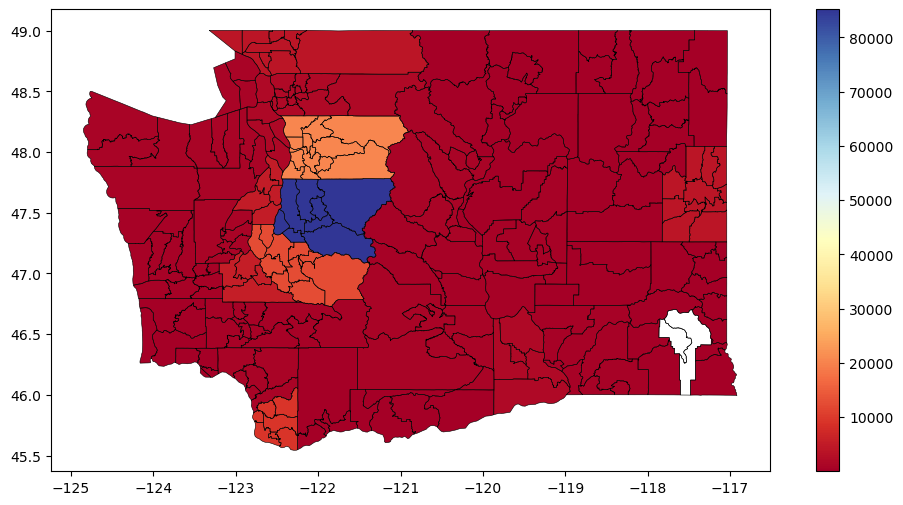

In [15]:
##plotting the map including a legend. The ax line of code creates a plot of the boundaries of the geometries in the 
## shape GeoDataFrame
## The second line of code plots the geometries on the exisiting axis (ax). The "Count" column is used to color 
## the geometries
## I don't like the initial look of the map as each county is broken down by cities. It is hard to distinguish counties.This
## is resolved with a different map below. 

ax=shape.boundary.plot(edgecolor='black', linewidth=0.4, figsize=(12,6))
shape.plot(ax=ax, column='Count', legend=True, cmap='RdYlBu', legend_kwds={'shrink':1.0})

plt.show()

### A "cleaned up" version where a title is given, the black outline (spine) is removed, and the x and y axis are removed. Additionally I changed the color map to see if the visual was better and easier to "read". 

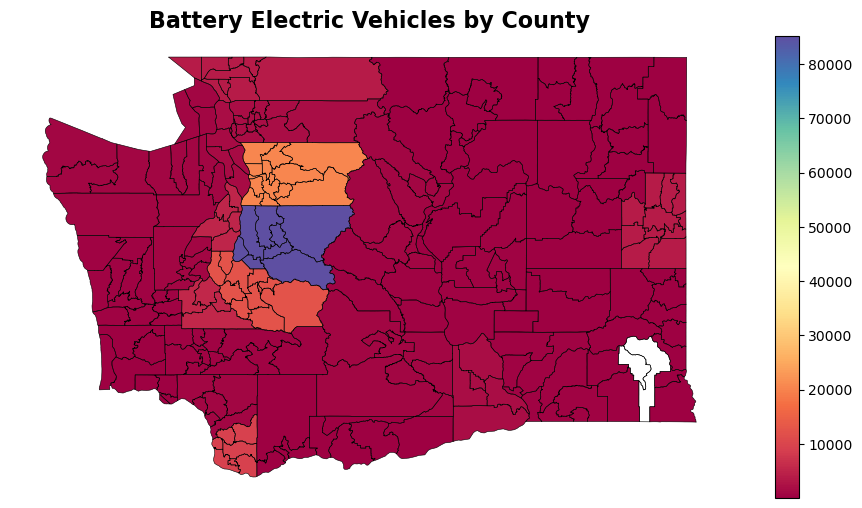

In [16]:
## This is the final map removing the text for the x and y axis, removing the black line (spine) from around the map, and
## adding a title to the map. 

ax=shape.boundary.plot(edgecolor='black', linewidth=0.4, figsize=(12,6))
shape.plot(ax=ax, column='Count', legend=True, cmap='Spectral', legend_kwds={'shrink':1.0})

##this following gets rid of the text for the x and y axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

##getting rid of the black "spines" around the map
for edge in ['right', 'left', 'bottom', 'top']:
    ax.spines[edge].set_visible(False)

##setting a title
ax.set_title('Battery Electric Vehicles by County', size=16, weight='bold')

plt.show()

## As referenced above I don't like the cluttered/messiness of the map(s) above. I found a map of Washington state that outlines the counties. Below is how I added this to the notebook. 

### Adding the "new" map file to this notebook

In [17]:
shape_path2 = r'C:\Users\v-joecamp\OneDrive - Microsoft\Desktop\Python Beginner Projects\EV stats\WA_County_Boundaries.shp'

### Create a geopandas dataframe and look at the columns and data to understand how and what to use to merge the df_bev_counties data frame with this one. 

In [18]:
## Used GeoPandas to read the file and create a geo df named shape2. Looking through the column names and corresponding data
## the column JURISDIC_2 listed each county. I will use this column and the County column from df_bev_county to merge the 
## two dataframes. 

shape2 = gpd.read_file(shape_path2)

print(shape2)

    OBJECTID  JURISDICT_  JURISDIC_1    JURISDIC_2           JURISDIC_3  \
0     309430          25           4         Grant         Grant County   
1     313589          33           4      Garfield      Garfield County   
2     313951           8           4        Island        Island County   
3     314575     4699350           4      Kittitas      Kittitas County   
4     314618          35           4   Walla Walla   Walla Walla County   
5     314637          34           4      Columbia      Columbia County   
6     314678          32           4        Asotin        Asotin County   
7     314694          29           4      Franklin      Franklin County   
8     314725     4698174           4  Pend Oreille  Pend Oreille County   
9     314747           7           4       Clallam       Clallam County   
10    314748          28           4       Pacific       Pacific County   
11    314752     4698173           4       Stevens       Stevens County   
12    314784          17 

### Reviewing the columns and data types of this geo df I see that the JURISDIC_2 column of county names is the same data type (object) as the County column from df_bev_county. This is how I merge the two data frames. 

In [19]:
## looking at the data types for each column of the shape2 geo dataframe. Note that the data type of JURISDIC_2 is object. 
## This is the same data type for the column County from df_bev_county

shape2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OBJECTID    39 non-null     int32         
 1   JURISDICT_  39 non-null     int32         
 2   JURISDIC_1  39 non-null     int32         
 3   JURISDIC_2  39 non-null     object        
 4   JURISDIC_3  39 non-null     object        
 5   JURISDIC_4  39 non-null     int32         
 6   JURISDIC_5  39 non-null     int32         
 7   JURISDIC_6  0 non-null      object        
 8   EDIT_DATE   39 non-null     datetime64[ms]
 9   EDIT_STATU  39 non-null     int32         
 10  EDIT_WHO    39 non-null     object        
 11  GLOBALID    39 non-null     object        
 12  geometry    39 non-null     geometry      
dtypes: datetime64[ms](1), geometry(1), int32(6), object(5)
memory usage: 3.2+ KB


### Merging the df_bev_county dataframe into the shape2 geo dataframe. Tehn look columns to confirm merge succeeded. 

In [20]:
#Merging shape2 geo data frame and df_bev_column

shape2= pd.merge(
    left=shape2,
    right=df_bev_county,
    left_on='JURISDIC_2',
    right_on='County',
    how='left'
)

print(shape.columns)

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'County', 'Count'],
      dtype='object')


### Take a quick look at the new geo data frame

In [21]:
shape2.head()

,OBJECTID,JURISDICT_,JURISDIC_1,JURISDIC_2,JURISDIC_3,JURISDIC_4,JURISDIC_5,JURISDIC_6,EDIT_DATE,EDIT_STATU,EDIT_WHO,GLOBALID,geometry,County,COUNTYFP,Count
0,309430,25,4,Grant,Grant County,13,53025,None,2018-03-15,1,TSTE490,{B37FC8E0-129C-41BA-9ECF-EC06BB5F86C8},"POLYGON ((-13245041.204 6100462.041, -13245049...",Grant,25.0,503.0
1,313589,33,4,Garfield,Garfield County,12,53023,None,2022-06-23,1,TSTE490,{5FF8494E-1147-4423-BAA6-84F5EBE38395},"POLYGON ((-13077215.155 5893282.479, -13076922...",NaN,NaN,NaN
2,313951,8,4,Island,Island County,15,53029,None,2018-03-15,1,TSTE490,{9BDB6294-4D31-49FD-8623-2496B8C2D704},"POLYGON ((-13645903.473 6175425.382, -13645833...",Island,29.0,1652.0
3,314575,4699350,4,Kittitas,Kittitas County,19,53037,None,2023-07-27,0,TSTE490,{7CB03435-CD6B-4D40-A61D-ED231A46F664},"POLYGON ((-13482428.89 6040101.397, -13482417....",Kittitas,37.0,610.0
4,314618,35,4,Walla Walla,Walla Walla County,36,53071,None,2015-10-14,1,JDUG490,{C539E72A-5339-484E-8754-05FE73F84DFB},"POLYGON ((-13170470.944 5878093.595, -13170220...",Walla Walla,71.0,358.0


### Build an initial map. This looks so much better and easier to read- uncluttered

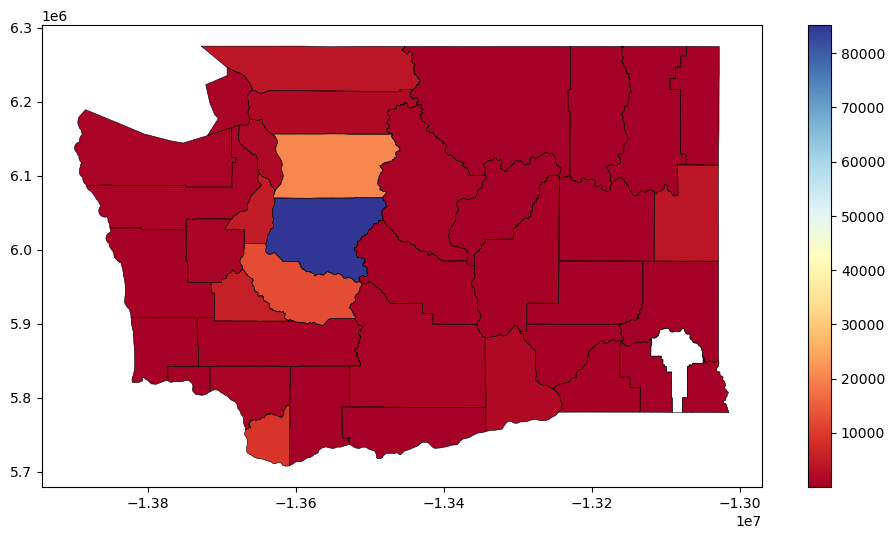

In [22]:
##Leveraging the map plotting code from above - plotting the map including a legend. 

ax=shape2.boundary.plot(edgecolor='black', linewidth=0.4, figsize=(12,6))
shape2.plot(ax=ax, column='Count', legend=True, cmap='RdYlBu', legend_kwds={'shrink':1.0})

plt.show()

### Final map - removed the spine, removed the x and y axis, and added a title. 

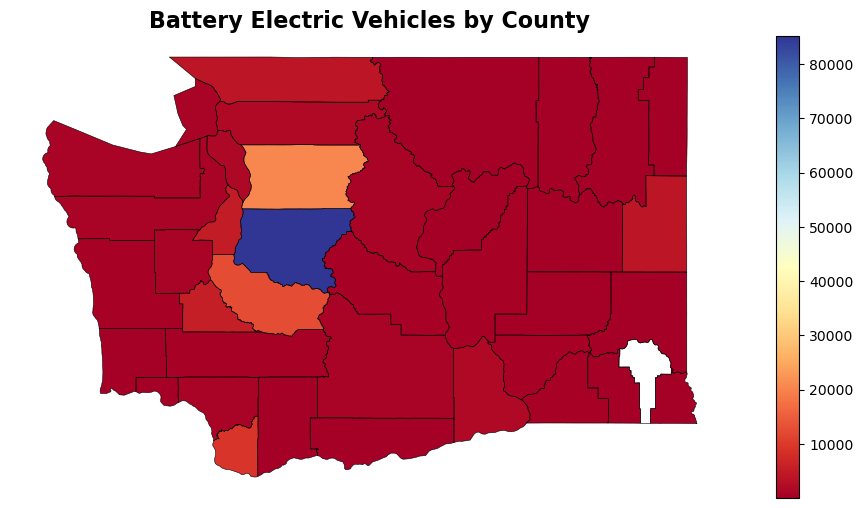

In [23]:
## Final map

ax=shape2.boundary.plot(edgecolor='black', linewidth=0.4, figsize=(12,6))
shape2.plot(ax=ax, column='Count', legend=True, cmap='RdYlBu', legend_kwds={'shrink':1.0})

##this following gets rid of the text for the x and y axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

##getting rid of the black "spines" around the map
for edge in ['right', 'left', 'bottom', 'top']:
    ax.spines[edge].set_visible(False)

##setting a title
ax.set_title('Battery Electric Vehicles by County', size=16, weight='bold')

plt.show()